In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Regulation Environment

In [95]:
from pyosrd import OSRD
from pyosrd.schedules import schedule_from_osrd, Schedule
from pyosrd.regul_env import RegulEnv

In [96]:
import gymnasium as gym
from gymnasium import spaces

class RegulationEnv(gym.Env):

    def __init__(
        self,
        initial_schedule,
        delayed_schedule,
        stations,
    ):
        self._initial_schedule = initial_schedule
        self._delayed_schedule = delayed_schedule
        self._schedule = delayed_schedule
        self._stations = stations

        self.action_space = spaces.Discrete(2)

    @property
    def schedule(self) -> Schedule:
        return self._schedule

    @property
    def initial_schedule(self) -> Schedule:
        return self._initial_schedule

    @property
    def stations(self):
        return self._stations
    
    @property
    def total_delay(self):
        return self._schedule.total_delay_at_stations(
            self._initial_schedule,
            self._stations
        )
    
    def reset(self):
        self._schedule = self._delayed_schedule

    def set_state(self, schedule: Schedule):
        self._schedule = schedule
    
    def step(self, action):

        where, train0, train1 = self._schedule.earliest_conflict()
        print(self._schedule.earliest_conflict())

        if (
            self._schedule.train_delay(train0, self._initial_schedule)
            > self._schedule.train_delay(train1, self._initial_schedule)
        ):
            most_delayed, least_delayed = train0, train1
        else:
            most_delayed, least_delayed = train1, train0
        
        if action == 0:
            self._schedule = \
                self._schedule.shift_train_after(
                    most_delayed,
                    least_delayed,
                    where
                )
        else:
            self._schedule = \
                self._schedule.shift_train_after(
                    least_delayed,
                    most_delayed,
                    where
                )
        
        reward = - self.total_delay
        self._done = self.schedule.earliest_conflict()[0] is None
        
        return _, reward, self._done, {}
    
    def render(self):
        self._schedule.plot()

In [97]:
sim = OSRD(use_case='cvg_dvg', dir='tmp2')

[16:54:52,635] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp2/infra.json
[16:54:52,680] [INFO]              [FullInfra] parsing infra
[16:54:52,763] [INFO]              [FullInfra] adaptation to kotlin
[16:54:52,804] [INFO]              [FullInfra] loading signals
[16:54:52,810] [INFO]              [FullInfra] building blocks
[16:54:52,818] [INFO]  [StandaloneSimulationCommand] Loading input: tmp2/simulation.json
[16:54:52,834] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.13
[16:54:52,926] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.14
[16:54:52,932] [INFO]  [StandaloneSimulationCommand] All simulations completed
[16:54:52,933] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp2/results.json


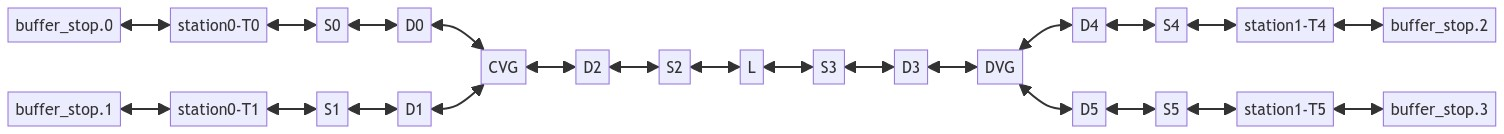

In [98]:
sim.draw_infra_points()

In [99]:

sim.add_train(
    label='train2',
    locations=[('T1', 300), ('T4', 480)],
    departure_time=200
)
sim.run()

[16:54:53,474] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp2/infra.json
[16:54:53,513] [INFO]              [FullInfra] parsing infra
[16:54:53,592] [INFO]              [FullInfra] adaptation to kotlin
[16:54:53,632] [INFO]              [FullInfra] loading signals
[16:54:53,639] [INFO]              [FullInfra] building blocks
[16:54:53,649] [INFO]  [StandaloneSimulationCommand] Loading input: tmp2/simulation.json
[16:54:53,668] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.13
[16:54:53,729] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.14
[16:54:53,736] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.15
[16:54:53,740] [INFO]  [StandaloneSimulationCommand] All simulations completed
[16:54:53,740] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp2/results.json


<Axes: xlabel='Time'>

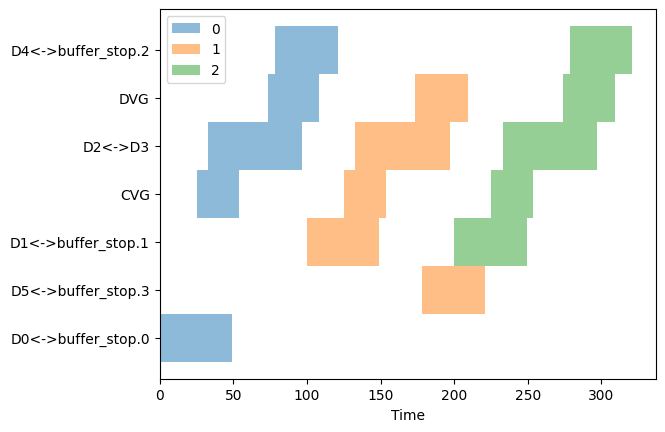

In [100]:
s = schedule_from_osrd(sim)
s.sort().plot()

In [101]:
s

                            0                       1                       2  \
                            s           e           s           e           s   
D0<->buffer_stop.0        0.0   49.271387         NaN         NaN         NaN   
CVG                 25.290046   53.626722  125.290046  153.626722  225.290046   
D2<->D3             32.871583   96.466092  132.871583  197.099453  232.871583   
D1<->buffer_stop.1        NaN         NaN       100.0  149.271387         200   
DVG                 73.617113  108.066092  173.658637   209.36612  273.658637   
D4<->buffer_stop.2  78.205627  121.066092         NaN         NaN  278.304105   
D5<->buffer_stop.3        NaN         NaN  178.304105  220.699453         NaN   

                                
                             e  
D0<->buffer_stop.0         NaN  
CVG                 253.626722  
D2<->D3             297.099453  
D1<->buffer_stop.1  249.271387  
DVG                  309.36612  
D4<->buffer_stop.2  320.699453  
D5<->b

<Axes: xlabel='Time'>

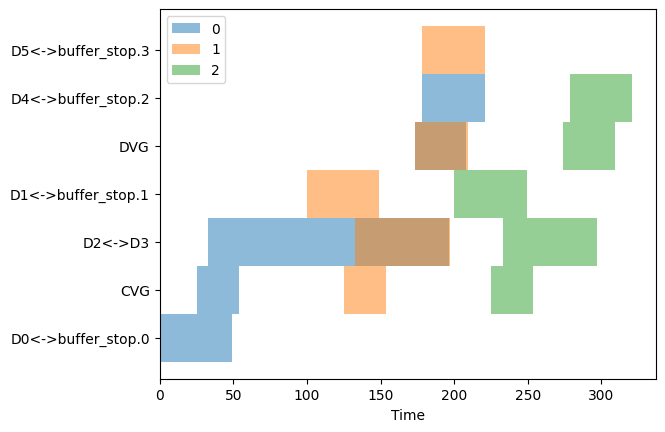

In [102]:
s.add_delay(0, 'D2<->D3', 100).plot()

In [103]:
sim.reset_delays()
sim.add_delay('train0', time_threshold=10, delay=120.)
delayed = sim.delayed()
ds = schedule_from_osrd(delayed)

In [104]:
env = RegulationEnv(
    initial_schedule=s,
    delayed_schedule=ds,
    stations=['D4<->buffer_stop.2', 'D5<->buffer_stop.3']
)

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/

('CVG', 1, 0)


/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal



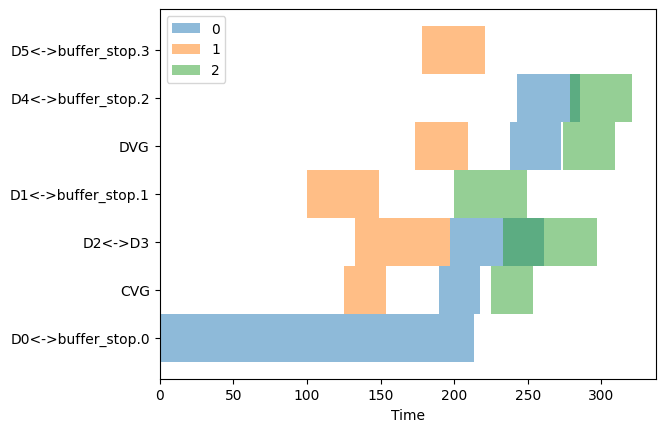

In [126]:
env.reset()
_, reward, done, _ = env.step(0)
env.render()

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/

('CVG', 1, 0)
-203.5945088038074 False


/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/

('D1<->buffer_stop.1', 1, 2)
-236.46040435012998 False


/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/

('D2<->D3', 1, 2)
-251.4168876830176 True


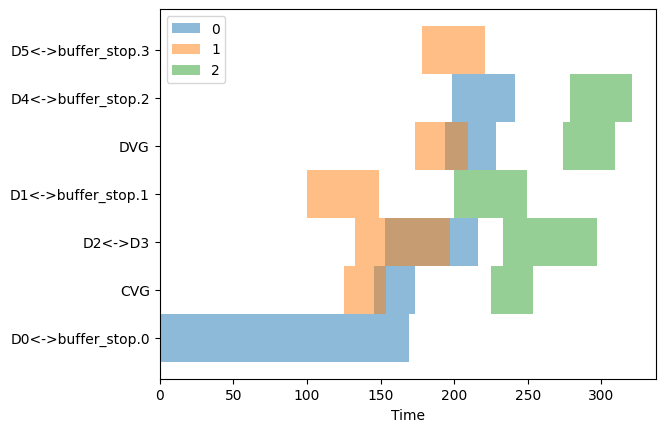

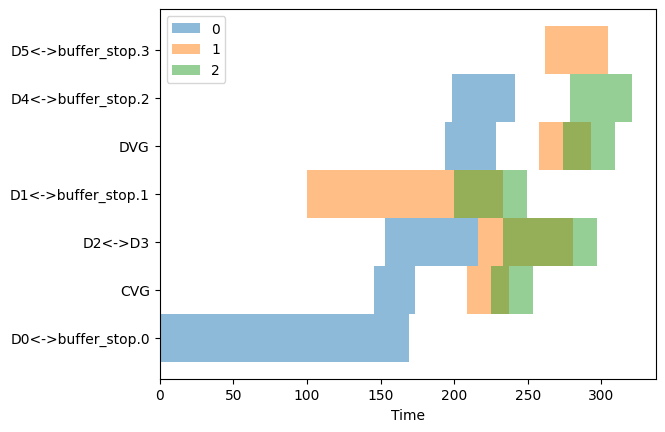

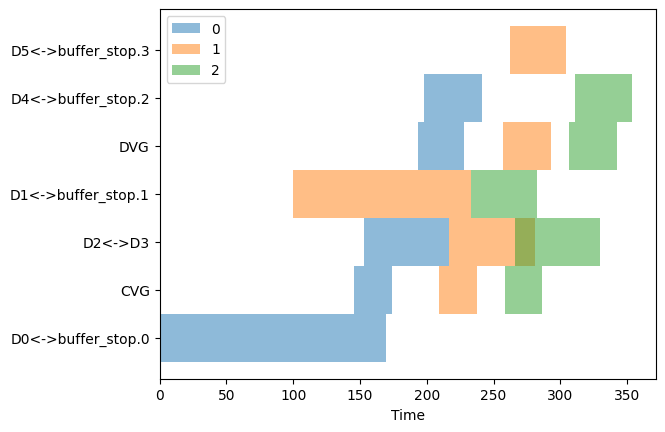

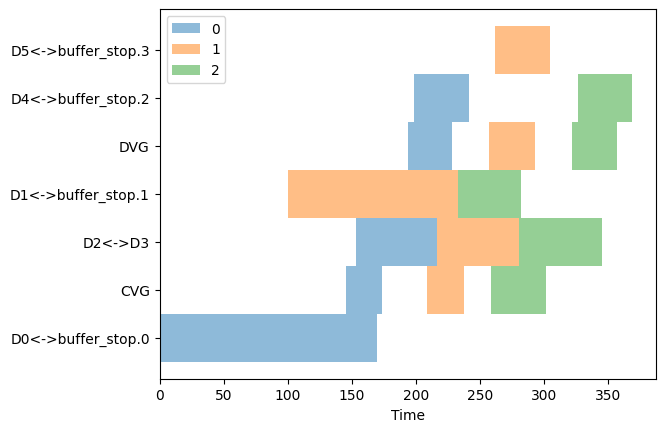

In [105]:
env.reset()
env.render()
for action in [1,1,1,1]:
    
    _, reward, done, _ = env.step(action)
    env.render()
    print(reward, done)
    if done:
        break

In [106]:
s.is_just_after_a_point_switch(1,2,'D2<->D3',)

False

In [107]:
from pyosrd.schedules import step_type


In [108]:
def previous_stop(schedule: Schedule, train, zone, step_type) -> str | None:
    
    if zone not in schedule.trajectory(train=train):
        return
    idx = schedule.trajectory(train=train).index(zone)
    return next(z for z in schedule.trajectory(train=train)[:idx][::-1] if step_type.loc[z, train] != 'switch')

def previous_station(schedule: Schedule, train, zone, step_type) -> str | None:
    
    if zone not in schedule.trajectory(train=train):
        return
    idx = schedule.trajectory(train=train).index(zone)
    return next(z for z in schedule.trajectory(train=train)[:idx][::-1] if step_type.loc[z, train] =='station')

In [109]:
previous_stop(s, 1, 'D5<->buffer_stop.3', step_type=step_type(sim))
previous_station(s, 1, 'D5<->buffer_stop.3', step_type=step_type(sim))

'D1<->buffer_stop.1'

In [110]:
step_type(sim)

,0,1,2
D0<->buffer_stop.0,station,NaN,NaN
CVG,switch,switch,switch
D2<->D3,signal,signal,signal
D1<->buffer_stop.1,NaN,station,station
DVG,switch,switch,switch
D4<->buffer_stop.2,station,NaN,station
D5<->buffer_stop.3,NaN,station,NaN


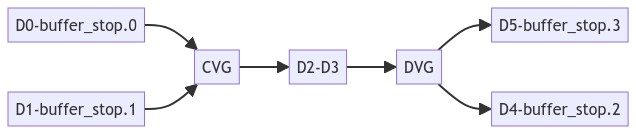

In [111]:
s.draw_graph()

In [112]:
import pandas as pd

def give_priority(
    self,
    train_with_priority: int | str,
    other_train: int | str,
    zone: int | str,
    step_type: pd.DataFrame
):
    other_train_waits_at = previous_stop(
        self,
        other_train,
        zone,
        step_type
    )

    if step_type.loc[zone,other_train] == 'switch':
        zone_ref = self.next_block(other_train, zone)
    else:
        zone_ref = zone
        
    other_train_wait_duration =(
        self.ends.loc[zone_ref, train_with_priority]
        - self.starts.loc[zone_ref, other_train]
    )
    
    
    new_schedule = self.add_delay(
        other_train,
        other_train_waits_at,
        other_train_wait_duration
    )

    return new_schedule

/home/renan/RLway/venv/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal



('D1<->buffer_stop.1', 2)

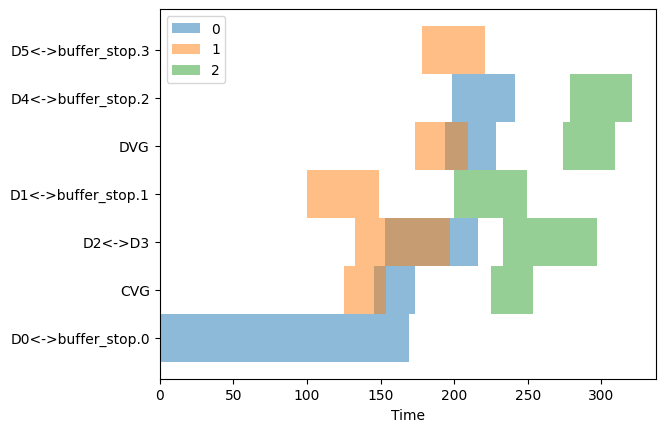

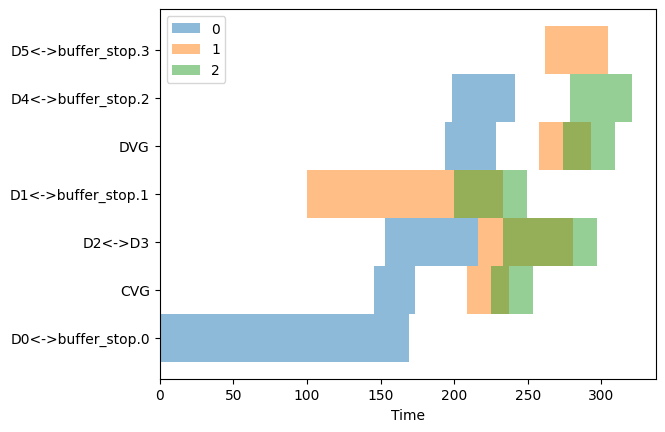

In [113]:
ds.plot()
d = give_priority(ds, 0, 1, 'CVG', step_type(sim))
d.plot()
d.first_conflict(1)


# c2y13s

In [114]:
# sim = OSRD(use_case='c2y13s', dir='tmp3')

In [115]:
# sim.space_time_chart_plotly(0)

In [123]:
# sim.draw_infra_points()

In [117]:
# from pyosrd.set_trains import copy_train

In [118]:
# copy_train(sim, 'train0', 'new_train0', 1000)
# copy_train(sim, 'train1', 'new_train1', 1100)

In [119]:
# sim.run()

In [120]:
# sim.trains

In [121]:
# sim.space_time_chart_plotly(0)

In [122]:
# s = schedule_from_osrd(sim)
# s.sort().plot()